In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch

In [10]:
# file = '../log/merciless-citadel_d6ee0c50-7859-4e8b-8caa-79e60351e44b.jsonl'
# file = '../log/merciless-citadel_08056352-e17c-4c5d-8fb7-3ceafd0a5c31.jsonl' # 
# file = '../log/merciless-citadel_5d15da5a-2f4a-4d6c-a99b-e70ea541a368.jsonl' # mean/std over 131,000 tokens
# file = '../log/merciless-citadel_75dab518-4696-4d94-9ab6-c12460c006b1.jsonl' # all inputs normalized using the above
# file = '../log/merciless-citadel_52fcf8bc-c7fc-4e00-b7d6-8f935ace900a.jsonl' # as above, but we manually assign the std of 447 to 600
# file = '../log/merciless-citadel_e89d0e1c-b96d-4172-aec2-eb66fa8fde98.jsonl' # go back to the actual std and reinitialize weights to normal distributions
# file = '../log/merciless-citadel_4c05b8ac-766e-43b1-9937-aff368c0db3a.jsonl' # learning rate 1e-3 instead of 1e-2
# file = '../log/merciless-citadel_5e783156-8a79-4fc2-a4a1-d2a13830e3d7.jsonl' # add biases
# file = '../log/merciless-citadel_f28ae42d-318d-4d8f-a58f-f31c79cb27c5.jsonl' # long training run
# file = '../log/merciless-citadel_bcce584c-091e-433b-9722-7c3c279b80b2.jsonl' # log biases too
# file = '../log/merciless-citadel_f81a3725-f403-4ce1-a1e4-e6b61d6295a9.jsonl' # log latents
# # file = '../log/merciless-citadel_1d84569a-0273-41f2-a675-3ef6ff7cf42f.jsonl' # gelu instead of Relu since we were getting lots of zeros in the latent
# # file = '../log/merciless-citadel_5586a705-69dc-4be9-8bcc-a6089677f020.jsonl' # file back to relu but with an initial enc bias of 5.15
# # file = '../log/merciless-citadel_73e458c1-04ba-4e40-92cb-efd7cd992fc4.jsonl' # tanh, no initial enc bias (normal * 0.01 instead)
# # file = '../log/merciless-citadel_b4cc674c-cac4-47df-a649-4026046aa1a2.jsonl' # tanh with previous weights scaled down
# # file = '../log/merciless-citadel_e2b0f80f-d821-46a9-a43e-99f9a308b67f.jsonl' # no more scaling, leaky relu instead of tanh, just as bad as relu, it turns out
# file = '../log/merciless-citadel_aad3b385-f049-446d-8364-56822904c948.jsonl' # back to relu, add l1 loss
 
# file = '../log/merciless-citadel_73415339-627f-44a9-b445-19c17f1ae6e4.jsonl' # collecting mean and std again over 512 files, 407,896,064 tokens, 24576 features, 55mbps
# file = '../log/merciless-citadel_6814b0ee-6a54-4353-b3a1-b3e38d34386e.jsonl' # collecring mean and std again, 128 features, 407,896,064 tokens

# file = '../log/merciless-citadel_12b18403-84f1-4ae2-a374-81fe0a8cae46.jsonl' # switchsae, relu, just a few for checking sanity
# file = '../log/merciless-citadel_ce77230a-7264-4c44-81f6-09745ea6b434.jsonl' # switchsae, relu, just a few for checking sanity
# file = '../log/merciless-citadel_19e2adc7-a894-41b3-8623-8b02d3adf65c.jsonl' # switchsae 1e-2 leraning rate
# file = '../log/merciless-citadel_f8120e80-e18c-4fbd-b338-86de57ae8feb.jsonl' # switchsae smaller batch size, back ro 1e-3
# file = '../log/merciless-citadel_e198c2b8-b012-4466-a995-2a2ce5680ed4.jsonl' # switchsae scaled MSE loss 
# file = '../log/merciless-citadel_0eda7109-0616-4760-8e1c-56a38a4b7867.jsonl' # topk switchsae (scaled mse still), slightly faster

files = [
     '../log/merciless-citadel_e198c2b8-b012-4466-a995-2a2ce5680ed4.jsonl', # switchsae scaled MSE loss 
    '../log/merciless-citadel_0eda7109-0616-4760-8e1c-56a38a4b7867.jsonl', # topk switchsae (scaled mse still), slightly faster, k=20
    '../log/merciless-citadel_3d386022-0e26-4e65-93bb-1b6709c3907e.jsonl', # topk switchsae, k=64
    '../log/merciless-citadel_e52fab04-faca-47e2-bf3d-6ba115df259e.jsonl', # topk switchsae, k=64, learning rate 1e-4
    '../log/merciless-citadel_cd172f63-f843-4062-a05d-dc2306a6cec3.jsonl', # topk switchsae, k=64, learning rate 5e-4
    # '../log/merciless-citadel_903f4cbf-4476-447b-abc1-f27206c89c9f.jsonl', # topk switchsae, k=128, lr=1e-3
    # '../log/merciless-citadel_d5c335fe-1098-4ff0-98b7-809e57753910.jsonl', # topk switchsae, k=32, lr=1e-3, mirror enc and dec init
    # '../log/merciless-citadel_b24f11ea-1b52-48c2-805d-72a65b614765.jsonl', # topk switchsae, k=32, lr=1e-3, mirror enc and dec init, triton decode
    '../log/merciless-citadel_d1eae76a-5b44-42d2-a526-655c9619d0ae.jsonl', # topk, k=32, lr=1e-4 (same as elutherai), eagre decode, aiming for 0.18
    '../log/merciless-citadel_af7b581f-a184-4fde-adcc-16b95ef7608c.jsonl', # top32, lr=2e-4, eagre, add in pre-bias
    '../log/merciless-citadel_464b4a61-2a8a-4677-985c-c57cce72a068.jsonl', # top32, lr=2e-4, add expert privilege loss
    '../log/merciless-citadel_35759180-fa36-41f6-b487-48052d7c36d6.jsonl', #top32, lr-1e-4, epl 
]
infos = []
for file in files:
    rows = []
    with open(file) as f:
        lines = f.readlines()
        for l in lines:
            rows.append(json.loads(l))


    info = defaultdict(list)

    for row in rows:
            for k in ['mbps', 'enc', 'dec', 'enc_b', 'dec_b', 'delta_hist', 'input_hist', 'reconstruction_hist', 
                    'latent_hist', 'rmse', 'mse', 'scaled_mse', 'input_mean', 'input_std', 'L0', 'L1', 'loss', 'dead_feature_prop', 'dead_latent_pct',
                    'experts_chosen_hist']:
                if k in row:
                    info[k].append(row[k])

    infos.append(info)

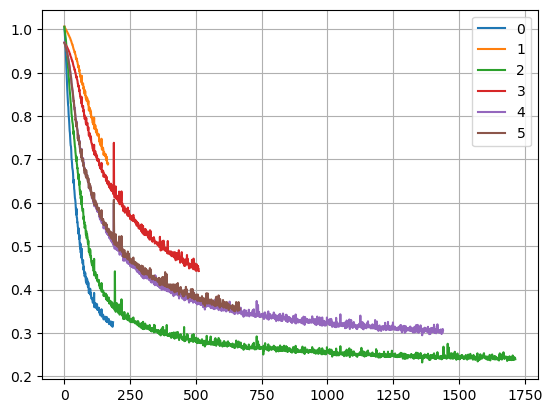

In [11]:
n = 4000
back = 6
for i in range(0, back):
    plt.plot(infos[-(back-i)]['scaled_mse'][:n], label=str(i))
plt.grid()
plt.legend()

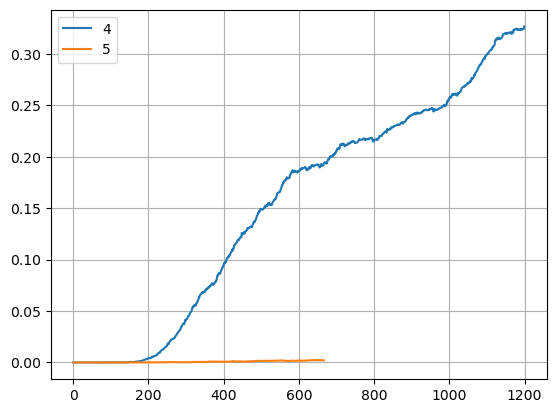

In [12]:
n = 1200
back = 6
for i in range(0, back):
    if 'dead_latent_pct' in infos[-(back-i)]:
        plt.plot(infos[-(back-i)]['dead_latent_pct'][:n], label=str(i))

    if 'dead_feature_prop' in infos[-(back-i)]:
        plt.plot(infos[-(back-i)]['dead_feature_prop'][:n], label=str(i))
plt.grid()
plt.legend()

In [13]:
list(info.keys())

['mse',
 'scaled_mse',
 'input_mean',
 'input_std',
 'L0',
 'loss',
 'dead_feature_prop',
 'delta_hist',
 'input_hist',
 'reconstruction_hist',
 'latent_hist',
 'experts_chosen_hist',
 'mbps']

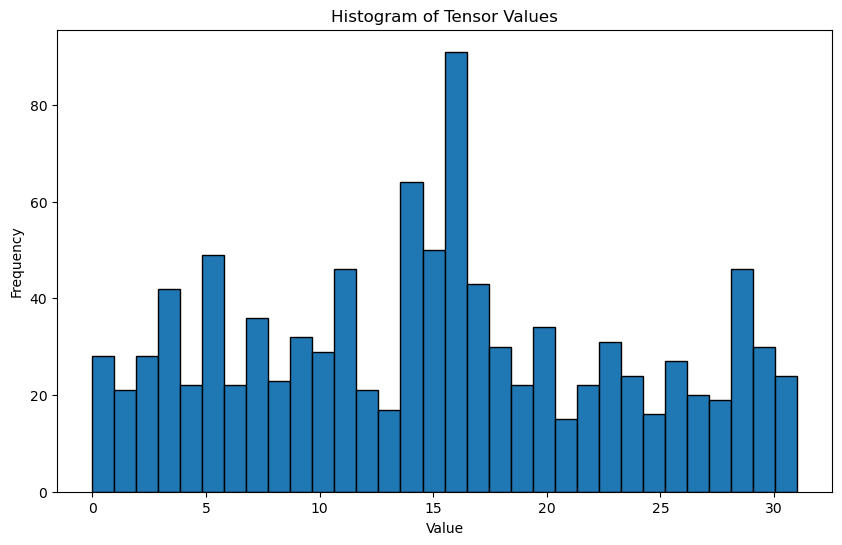

In [14]:
i = 0
h = info['experts_chosen_hist']
hist = np.array(h[i]['counts'])
edges = np.array(h[i]['edges'])
print()

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')  # Plot histogram

# Labeling the axes
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Tensor Values')

# Show the plot
plt.show()

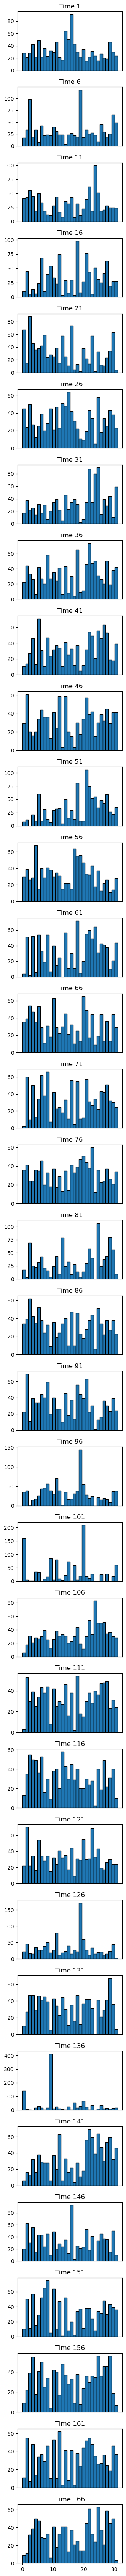

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Example structure: sae_encs = [{'counts': counts_data, 'edges': edges_data}, ..., {'counts': counts_data, 'edges': edges_data}]

# Define the grid size
info = infos[-1]
h = info['experts_chosen_hist']
num_hist = len(h)  # Number of histograms
cols = 5       # Number of columns in the plot grid
rows = num_hist // cols + (num_hist % cols > 0)  # Number of rows in the plot grid

# Create a large figure to hold all subplots
plt.figure(figsize=(15, 2 * rows))  # Adjust size as needed


for i in range(0, num_hist, 5):
    hist = np.array(h[i]['counts'])
    edges = np.array(h[i]['edges'])
    
    # Create a subplot for each histogram
    plt.subplot(rows, cols, i + 1)
    plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')
    
    # Optional: Hide labels to keep the plot clean, can be adjusted based on preference
    if i % cols != 0:  # Hide y labels for all but the first column
        plt.yticks([])
    if i < (rows - 1) * cols:  # Hide x labels for all but the last row
        plt.xticks([])
    
    # Optionally add a title to each subplot
    plt.title(f'Time {i+1}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [102]:
import json
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np

718.8284073725058 65.59315301145257
729.6571370173424 80.02629557308315
677.8943103037689 34.36686028753744
707.4728405575698 47.430122181021524
628.4940051225677 16.784234518683736
625.0170365165263 16.81196902808385


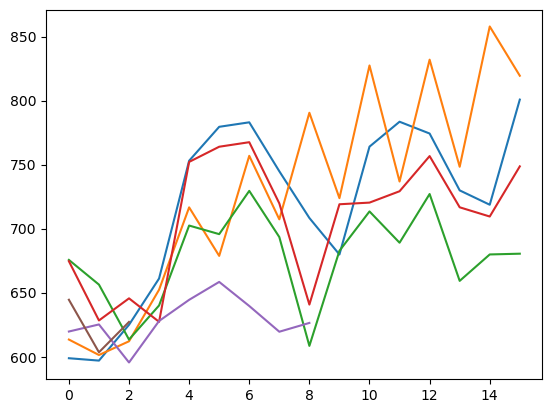

In [29]:
for file in [
    '../cruft/graceful-oboe-stats.json', # after new generation
    '../cruft/colorful-scrub-stats.json',  # after caching
    '../cruft/isomorphic-pagoda-stats.json',  # reproduction
    '../cruft/mute-barrage-stats.json',  # single session
    '../cruft/inventive-em-stats.json',  # single session
    '../cruft/bounded-onion-stats.json',  # single session

]:

    with open(file) as f:
        data = json.load(f)

    x = [row['MB per second'] for row in data[:40]]
    print(np.mean(x), np.std(x))
    plt.plot(x)

882.0417478425177 159.83764539290277
946.309197175772 125.84752078391618
888.0112681745152 96.27109515911319
869.8924592111802 125.15810727857414
878.3791029928616 114.55557468789492
836.1185012546023 100.13544805159168
466.46863130541914 38.550087902602904


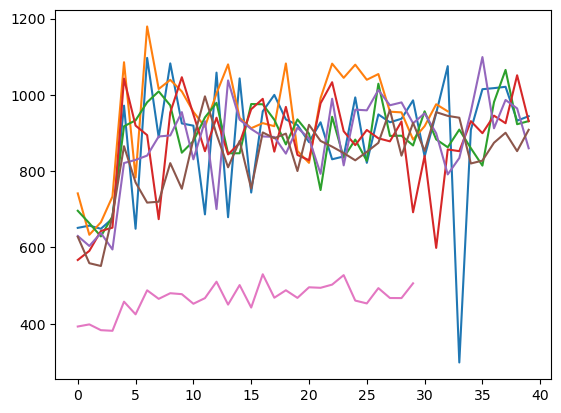

In [13]:
for file in [
    '../cruft/matching-siamese-stats.json', # logged off
    '../cruft/lower-draft-stats.json',  # logged in
    '../cruft/yummy-metaball-stats.json', # cachebusting
    '../cruft/vain-trie-stats.json', # cachebusting 2
    '../cruft/celeste-plisse-stats.json', # cachebusting + cycling files
    '../cruft/plain-culture-stats.json', # as above, through VPC endpoint
    '../cruft/direct-architecture-stats.json', # https
    '../cruft/colorful-scrub-stats.json', # https



]:

    with open(file) as f:
        data = json.load(f)

    x = [row['MB per second'] for row in data[:40]]
    print(np.mean(x), np.std(x))
    plt.plot(x)

In [12]:
len(data)

29

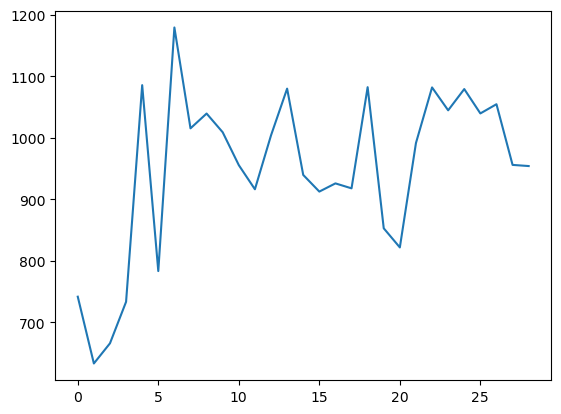

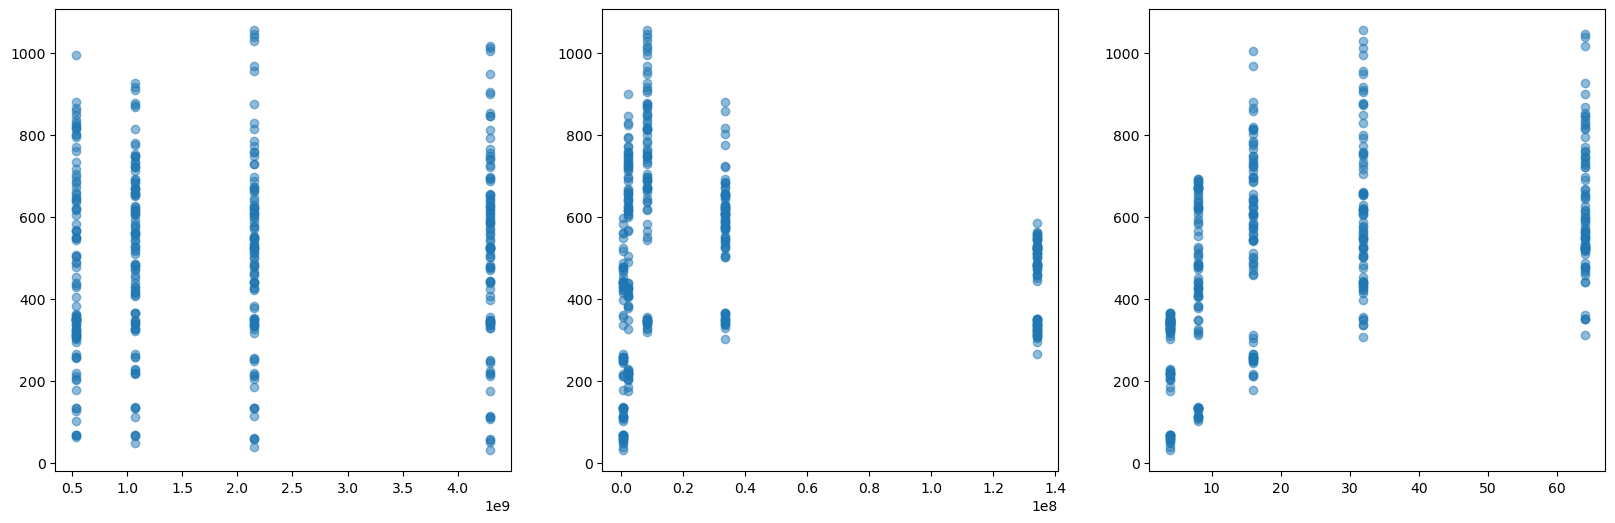

In [13]:
param_hashes = set([row['param_hash'] for row in data])
keys = [
    'MB per second',
    'total_size',
    'chunk_size',
    'n_threads'
]


values = defaultdict(list)

for row in data:
    for key in keys:
        values[key].append(row[key])


fg, ax = plt.subplots(1, 3, figsize=(20, 6))


ax[0].scatter(values['total_size'], values['MB per second'], alpha=0.5)
ax[1].scatter(values['chunk_size'], values['MB per second'], alpha=0.5)
ax[2].scatter(values['n_threads'], values['MB per second'], alpha=0.5)








In [17]:
1e8 * 0.1 / (1024 * 1024)

9.5367431640625

In [16]:
1e8 * 0.4 / (1024 * 1024)

38.14697265625

In [14]:
avgs = defaultdict(float)

for d in data:
    avgs[d['param_hash']] += d['MB per second']

for k in avgs:
    avgs[k] /= 4

# print the keys for the 4 highest averages


sorted_avgs = sorted(avgs.items(), key=lambda x: x[1], reverse=True)
for k, v in sorted_avgs[:8]:
    print(k, v)

8.0_32_2048.0 979.0194597515592
8.0_64_2048.0 906.7866035322465
8.0_32_4096.0 905.6151790358128
8.0_32_1024.0 894.5695572599446
8.0_64_4096.0 854.0122665562293
8.0_32_512.0 837.3243812283725
8.0_16_4096.0 831.1037215505453
8.0_64_1024.0 808.4690267603278


In [45]:
for d in data:
    if d['MB per second'] > 800:
        print(round(d['chunk_size'] / (1024*1024), 2), round(d['total_size'] / (1024*1024), 2), d['n_threads'], round(d['MB per second']))

2.0 2048.0 32 829
2.0 512.0 64 825
2.0 4096.0 64 846
2.0 4096.0 64 899
8.0 512.0 16 819
8.0 512.0 16 814
8.0 512.0 16 866
8.0 1024.0 16 815
8.0 2048.0 16 968
8.0 4096.0 16 813
8.0 4096.0 16 1004
8.0 512.0 32 995
8.0 512.0 32 849
8.0 1024.0 32 874
8.0 1024.0 32 917
8.0 1024.0 32 877
8.0 1024.0 32 910
8.0 2048.0 32 875
8.0 2048.0 32 957
8.0 2048.0 32 1056
8.0 2048.0 32 1029
8.0 4096.0 32 1012
8.0 4096.0 32 905
8.0 4096.0 32 949
8.0 512.0 64 828
8.0 512.0 64 836
8.0 1024.0 64 868
8.0 1024.0 64 927
8.0 2048.0 64 813
8.0 2048.0 64 1046
8.0 2048.0 64 1038
8.0 4096.0 64 855
8.0 4096.0 64 1018
8.0 4096.0 64 845
32.0 512.0 16 802
32.0 512.0 16 857
32.0 512.0 16 881
32.0 512.0 64 817


In [3]:
import json

import matplotlib.pyplot as plt
import numpy as np

bp 4100
3300.22 seconds
11797.051854737889 8.476694112337767e-05 ../log/active-camera_bd0696af-6e92-4341-8507-ae7c8e634957.jsonl


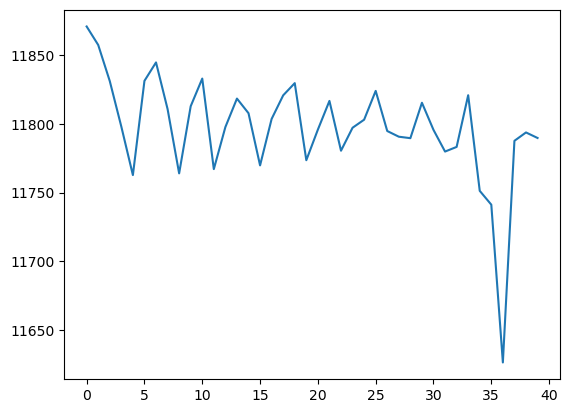

In [6]:
filenames = [
    # '../log/covering-deductible-frame-local_0408e05c-2262-473b-a19d-e3d247cc493e.jsonl',
    # '../log/corn-template-normal-s3_ec81d834-2b97-4df2-bb31-5c5579eb5417.jsonl',
    # '../log/beige-pint-mouth-noop_048141ea-c6cc-4e06-929f-acebf0fe4f30.jsonl',
    # '../log/espressivo-factorial-state-s3_threaded_1103ee48-4427-480c-abad-49db1e262c87.jsonl',
    # '../log/absolute-tuba-configuration-768_412a198c-fdd6-4637-9aa8-0ba5b3c5cd13.jsonl',
    # '../log/damp-fort-guard-1024_a238ec83-2dbb-4667-ab1e-8a6accd1fd2a.jsonl',
    # '../log/patient-rabbit-768-noop_b3aaf332-8a0c-4e5b-a7dd-926849007bbb.jsonl',
    # '../log/brilliant-function-1024-noop_3a84947d-3e75-4438-8fde-5009966f26fb.jsonl',
    # '../log/thick-meter-768-s3_threaded_3417f6d8-c38d-49f8-ab0c-75e13d7e5d46.jsonl',
    # '../log/isobaric-newton-1024-s3_threaded_b385e53d-9f7c-4237-a4e1-28f857d16d0c.jsonl',
    # '../log/figurative-trim-768-noop_e8dee59c-ced0-43e2-980c-c6f5df3e6e7f.jsonl',
    # '../log/strong-valance-1024-noop_ebee7e09-979f-44d5-aa59-3862ff1a050e.jsonl',
    # '../log/woolen-margin-768-s3_threaded_65720572-4641-4417-bb21-36b18fc3876f.jsonl',
    # '../log/vertical-pita-1024-s3_threaded_859c8af6-222b-4e6e-8c93-a4c7315d942f.jsonl',
    # '../log/merry-quanta-512-noop-16_412b5764-e636-4b01-a5ea-91fab64a7389.jsonl',
    # '../log/full-pagoda-512-noop-8_1817daa8-d99d-4c82-b941-1879fe2636a4.jsonl',    
    # '../log/humble-automaton-512-s3_threaded-8_f45205e2-e64d-443c-a6dd-be7d18d44e9c.jsonl',
    # '../log/greasy-grout-512-s3_threaded-16_5f5def98-2d6e-4fae-962f-fd8c58b0d8fb.jsonl',
    # '../log/thundering-barracuda_ef4afaf1-8487-488b-b199-53aa8c791c98.jsonl',
    # '../log/reduced-kudzu_9ec0aa5f-2b79-4c3f-8cc9-6e11c9547afe.jsonl'
    '../log/active-camera_bd0696af-6e92-4341-8507-ae7c8e634957.jsonl'
]

for filename in filenames:
    data = []
    with open(filename) as f:
        # read all lines of the jsonl file
        lines = f.readlines()
        # parse each line as json
        for line in lines:
            data.append(json.loads(line))

    batches = [d for d in data if d['event'] == 'batch_processed']
    
    print('bp', batches[-1]['batches_processed'])

    total_elapsed = data[-1]['timestamp'] - data[0]['timestamp']

    print(round(total_elapsed, 2), 'seconds')

    sps = [d['samples_per_second'] for d in batches if 'samples_per_second' in d]
    plt.plot(sps, label=filename)
    print(np.mean(sps), 1/np.mean(sps), filename)

    usages = [d for d in data if d['event'] == 'system_usage']

    # plt.plot([u['torch.cuda.memory_allocated'] for u in usages])
    # plt.plot([u['torch.cuda.memory_reserved'] for u in usages])


# plt.legend()

    


In [5]:
batches[1].keys()

dict_keys(['event', 'batches_processed', 'activation_shape', 'activations_mean', 'activations_min', 'activations_max', 'activations_std', 'sample_mean_activations', 'sample_max_activations', 'sample_min_activations', 'sample_attention_mask', 'attention_mask_shape', 'attention_mask_sum', 'sample_plaintext', 'seconds_since_last_log', 'samples_per_second', 'timestamp', 'hr_timestamp'])

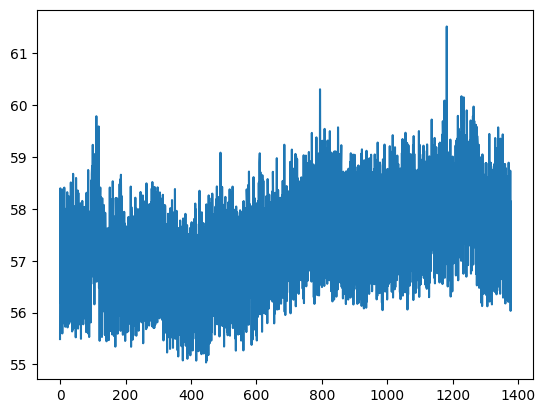

In [6]:
sps = [d['seconds_since_last_log'] for d in batches if 'seconds_since_last_log' in d]
plt.plot(sps, label=filename)

In [14]:
1_197_252_000 / 4

299313000.0

In [ ]:
60*1400 * 14253

In [13]:
60*1400 / 60 / 60 / 4

5.833333333333333

In [14]:
filenames = [
    '../log/thundering-barracuda_953b1120-4f81-4b8f-a177-9e2870e6fde2.jsonl'
]

data = []
with open(filenames[0]) as f:
    # read all lines of the jsonl file
    lines = f.readlines()
    # parse each line as json
    for line in lines:
        data.append(json.loads(line))

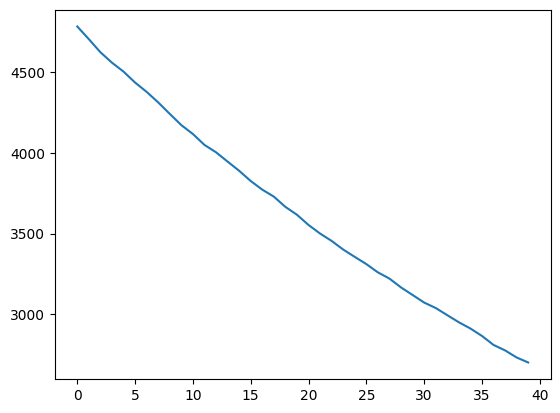

In [15]:
plt.plot([d['rmse'] for d in data])

In [23]:
for b in batches:

    if 'endof' in b['sample_plaintext']:
        print(b['sample_plaintext'])

 20,000 people in Manchester in February 1988. Section 28 caused real problems for people in their workplaces and schools due to self censorship. The law was finally repealed in 2003.<|endoftext|>Joe Robbins/Getty Images

Terrell Owens has been out of the NFL long enough to attain eligibility for the Pro Football Hall of Fame
 that it will lead to a range of new services. In fact, it may mean a host of yet unknown services that will deliver real value to consumers and society more generally.”<|endoftext|>Breaking News Emails Get breaking news alerts and special reports. The news and stories that matter, delivered weekday mornings.

July 22
 the authentic orange paint job is a little too garish for you, check out the original and (equally illustrious) Nakajima racer, a lovely blue R90/6. Is there a better custom BMW builder in the world today?<|endoftext|>Ikuze shining running forever!

Mae e tsu
<|endoftext|>whatfreshhellisthis-deactivated answered:

Put down the Nietzsche and stop bei

In [3]:
f"{1892800 * 512:,}"

'969,113,600'

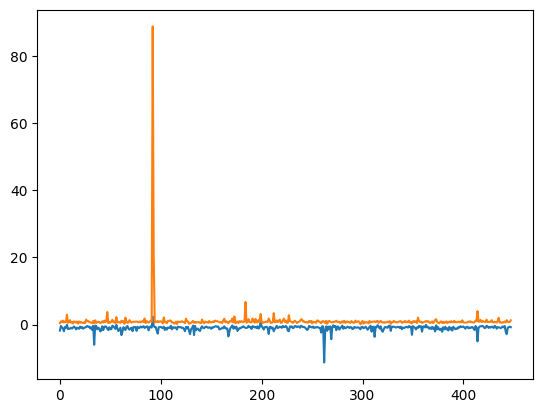

In [21]:
plt.plot(data[0]['sample_min_activations'])
plt.plot(data[0]['sample_max_activations'])



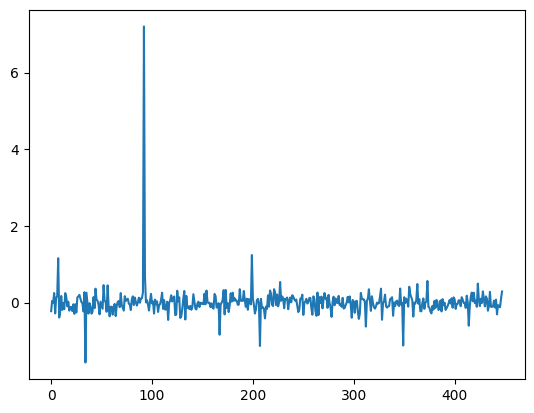

In [16]:
plt.plot(data[0]['sample_mean_activations'])

In [7]:
import torch

In [8]:
d = torch.load('../cache/00a0deec-3379-45f0-988a-ae1e483658a6.saved.pt')

/tmp/ipykernel_108756/1127678546.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load('../cache/00a0deec-3379-45f0-988a-ae1e483658a6.saved.pt')


In [9]:
d.shape

torch.Size([1024, 512, 1536])